In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

hfont = {'fontname':'Arial'}

In [2]:
def GetPrnSpectrum(Path,Name):  #written for spectra are tab delimited ASCII XY
    FPath = Path + Name         #needs to be replaced by whatever spectrum format you are using 
    f = open(FPath,'r')  
    lines = f.readlines()
    f.close()
    
    data = []
    for line in lines:
        p = line.split()
        data.append(p)
        
    data2 = np.array(data)
    data2 = data2.astype(float)
    x = data2[:,0]
    y = data2[:,1]
    return (x,y)


In [3]:
def SlopeCorrect(Y) :             # baseline correction routine
    nx = np.size(Y)
    S1 = np.mean(Y[0:9])
    S2 = np.mean(Y[nx-10:nx-1])
    BSL = np.linspace(S1,S2,num = nx)
    Y = np.subtract(Y,BSL)
    return(Y)
    

In [4]:
fpath ='E:/Cu Oxford Data/07092021/'       #all data are in single folder
Scale = 10000                              # arbitrary value for normalized double integral value


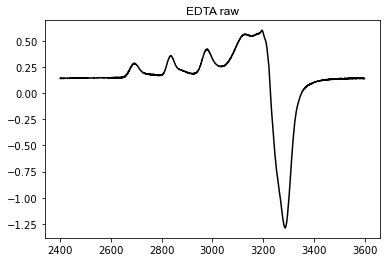

Field step : 0.5860


In [5]:
EDTAName = 'Sample2.prn'                   #read in the three 'static' spectra EDTA (xe,ye), Imidazole (xi,yi)
xe,ye = GetPrnSpectrum(fpath,EDTAName)     # and background (xb,yb)
dB = xe[1] - xe[0] 
plt.plot(xe,ye,'k')
plt.title("Cu EDTA raw", **hfont)
plt.show()
print("Field step : " "%5.4f" % dB)  

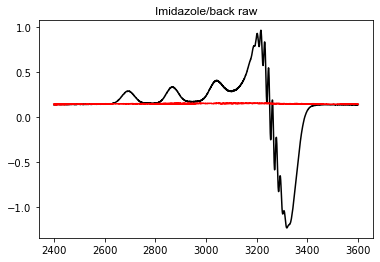

In [6]:
ImidName = 'Sample3.prn'
xi,yi = GetPrnSpectrum(fpath,ImidName)
plt.plot(xi,yi,'k-')
plt.title("Cu Imidazole/back raw", **hfont)

BackName = 'Sample1.prn'
xb,yb = GetPrnSpectrum(fpath,BackName)
plt.plot(xb,yb,'r-')
plt.show()

In [7]:
ye = np.subtract(ye,yb)               #one time processing of the two exemplar spectra, edta and imidazole
ye = SlopeCorrect(ye)                 #ye is Cu(EDTA)  yi is Cu(im)4
ME = np.mean(ye)
ye = ye - ME
yi = np.subtract(yi,yb)
yi = SlopeCorrect(yi)
MI = np.mean(yi)
yi = yi - MI

In [8]:
nx = len(xe)                        #create integral spectra and double integrals for the exemplars
IntegI = np.zeros((nx,1))           # again, one time processing, fixed for all RFQ samples.
IntegE = np.zeros((nx,1))
smi = 0
sme = 0

for i in range (0,nx-1) :             #simple endpoint summation for integration
    smi = smi + yi[i]
    sme = sme + ye[i]
    IntegI[i] = smi
    IntegE[i] = sme
    
DI = np.sum(IntegI)
DI = DI * dB * dB                         
yiN = yi*Scale/DI                      #normalized derivative y values denoted with N suffix

DE = np.sum(IntegE)
DE = DE * dB * dB
yeN = ye*Scale/DE

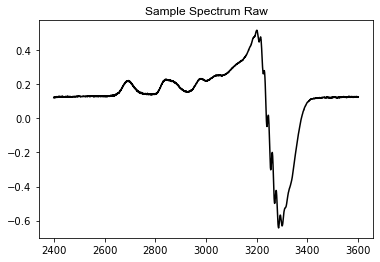

In [9]:
SampleName = "Sample5.prn"                      #this point and below can be rerun for each new sample to be tested
xs,ys = GetPrnSpectrum(fpath,SampleName)        #everything above is reused for each fit 
plt.plot(xs,ys,'k')
plt.title("Sample Spectrum Raw",**hfont)
plt.show()

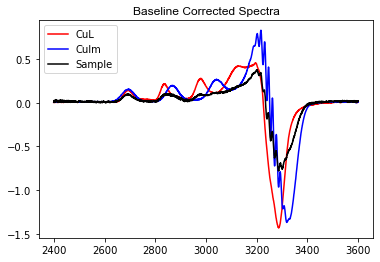

In [29]:
ys = np.subtract(ys,yb)
ys = SlopeCorrect(ys)
MS = np.mean(ys)
ys = ys - MS

plt.plot(xs,ye,'r', label = 'CuL')
plt.plot(xs,yi,'b', label = 'CuIm')
plt.plot(xs,ys,'k', label = 'Sample')
plt.title("Baseline Corrected Spectra", **hfont)
plt.legend(loc = 'upper left')
plt.show()

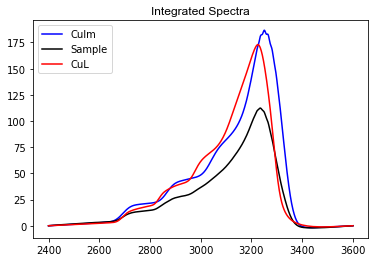

In [23]:
nx = len(xs)
IntegS = np.zeros((nx,1))

sms = 0

for i in range (0,nx-1) :
    sms = sms + ys[i]
    IntegS[i] = sms
          
plt.plot(xe,IntegI,'b',label = 'CuIm')
plt.plot(xe,IntegS,'k', label = 'Sample')
plt.plot(xe,IntegE,'r', label = 'CuL')
plt.legend(loc = 'upper left')
plt.title("Integrated Spectra", **hfont)

plt.show()

Double Integral values
Sample : 17843.44
CuL    : 25970.20
CuIm   : 28354.39


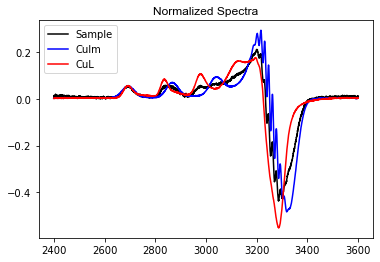

In [30]:
DS = np.sum(IntegS)
DS = DS * dB * dB
ysN = ys * Scale/DS

print("Double Integral values") 
print("Sample : " "%7.2f" % DS)
print("CuL    : " "%7.2f" % DE)
print("CuIm   : " "%7.2f" % DI)
    
plt.plot(xs,ysN,'k',label = 'Sample')
plt.plot(xi,yiN,'b',label = 'CuIm')
plt.plot(xs,yeN,'r',label = 'CuL')
plt.title("Normalized Spectra", **hfont)
plt.legend(loc = 'upper left')
plt.show()

In [20]:
Diff1 = np.subtract(yeN,yiN)         #create fit differences for 1 parameter fit
DiffS = np.subtract(ysN,yiN)

DF2 = np.dot(Diff1,Diff1)             # (SE - SIm)*(SE - SIm)
DF1 = np.dot(DiffS,Diff1)             #  (SX - SIm)*(SE - SIm)    

FrE = DF1 / DF2
FrI = 1 - FrE

print("Fraction EDTA bound  : " "%5.3f" % FrE)
print("Fraction unreacted   : " "%5.3f" % FrI)


Fraction EDTA bound  : 0.490
Fraction unreacted   : 0.510


ChiSquare : 0.0282
Stdev     : 0.0037


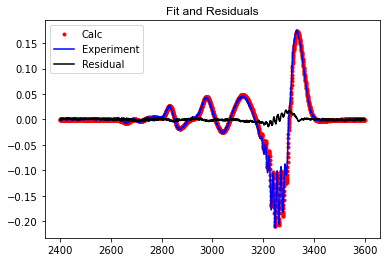

In [28]:
ycalc = FrE * Diff1
resid = DiffS - ycalc
chisq = np.dot(resid,resid)
stdv = np.std(resid)
print("ChiSquare : " "%6.4f" % chisq)
print("Stdev     : " "%6.4f"  % stdv)

plt.plot(xe,ycalc,'r.',label = 'Calc')
plt.plot(xe,DiffS,'b', label = 'Experiment')
plt.plot(xe,resid,'k', label = 'Residual')
plt.title("Fit and Residuals", **hfont)
plt.legend(loc = 'upper left')

plt.show()


In [18]:
R =  5          #ratio of CaL/Cu in solution
k =  21         #observed or predicted rate constant  

x = (1-FrE)/(1-FrE/R)     #x is exp(-kt)
TimeFQ = -math.log(x)/k   #TimeFQ is time in seconds 
print("Exponential decay  : " "%5.3f" % x)
print("Freeze Quench Time : " "%6.4f" % TimeFQ)

Exponential decay  : 0.566
Freeze Quench Time : 0.0271
